<a id="dynamic-soaring-notebook"></a>


# Dynamic Soaring

For a solution to the dynamic soaring problem using a Python script instead of a notebook, see the corresponding [Python script documentation](../scripts/dynamic_soaring.rst).


## Description

In 1883, Lord Rayleigh (John William Strutt, 3rd Baron Rayleigh) was the first to describe the mechanism of dynamic soaring, by which birds can maintain flight without flapping in the presence of wind gradients. He wrote <cite data-footcite="Rayleigh:1883">(Rayleigh, 1883)</cite>:

> The first step is, if necessary, to turn round until the relative motion is to leeward, and then to drop gradually down through the plane of separation. In falling down to the level of the plane there is a gain of relative velocity, but this is of no significance for the present purpose, as it is purchased by the loss of elevation; but in passing through the plane there is a really effective gain. In entering the lower stratum the actual velocity is indeed unaltered, but the velocity relatively to the surrounding air is increased. The bird must now wheel round in the lower stratum until the direction of motion is to windward, and then return to the upper stratum, in entering which there is a second increment of relative velocity. This process may evidently be repeated indefinitely; and if the successive increments of relative velocity squared are large enough to outweigh the inevitable waste which is in progress all the while, the bird may maintain his level, and even increase his available energy, without doing a stroke of work.

Zhao <cite data-footcite="Zhao:2004"/> formulated the dynamic soaring problem as an optimal control problem, and looked at optimizing a number of parameters, including the least required wind gradient slope that can sustain dynamic soaring flight. Darby et al. <cite data-footcite="Darby:2011"/> presented a solution using the LGR pseudospectral method implemented in the GPOPS software package. The example presented here is slightly modified version of that problem, implemented in YAPSS. (In our modification, the closed path is clockwise, so that larger bank angles are positive instead of negative.)

The states of the system are given by
$$
\begin{aligned}
   x(t) &= \text{distance north} \\
   y(t) &= \text{distance east} \\
   h(t) &= \text{altitude} \\
   v(t) &= \text{velocity} \\
   \gamma(t) &= \text{flight path angle} \\
   \psi(t) &= \text{heading angle}
\end{aligned}
$$
and the control inputs are
$$
\begin{aligned}
   C_{L}(t) &= \text{lift coefficient} \\
   \phi(t)  &= \text{bank angle (rad)}
\end{aligned}
$$
The differential equations for the states are given by
$$
\begin{aligned}
   \dot{x} &= v \cos\gamma \,\sin\psi + W_{x} \\
   \dot{y} &= v \cos\gamma \,\cos\psi \\
   \dot{h} &= v \sin\gamma \\
   \dot{v} &= -\frac{D}{m} - g \sin\gamma - \dot{W}_{x} \cos\gamma \,\sin\psi \\
   \dot{\gamma} &= \frac{1}{mv} \left(\,L \cos \phi - mg \cos \gamma
                     + m \dot{W}_{x} \sin\gamma \,\sin\psi\,\right) \\
   \dot{\psi} &= \frac{L \sin\phi - m \dot{W}_{x} \cos\psi}{m v\cos\gamma}
\end{aligned}
$$
The lift and drag are given by
$$
   L = q S C_{L}, \quad D = q S C_{D}
$$
where $S$ is the wing reference area, and the dynamic pressure is
$$
   q = \frac{1}{2} \rho v^{2}
$$
The drag coefficient is a constant (the profile drag) plus a term dependent of the lift coefficient
squared (the induced drag):
$$
   C_{D} = C_{D 0} + K C_{L}^{2}
$$
The winds are out of the north, with magnitude increasing linearly with altitutde, so that
$$
   W_{x} =\beta h, \quad \dot{W}_{x} =\beta \dot{h}
$$
The goal of this problem are to find the minimum value of the gradient $\beta$ that can
sustain a continuous cycle of dynamic soaring, that is to minimize
$$
   J = \beta
$$
subject to the boundary conditions
$$
\begin{aligned}
   x(t_f) &= x(0) = 0 \\
   y(t_f) &= y(0) = 0 \\
   h(t_f) &= h(0) = 0 \\
   v(t_f) &= v(0) \\
   \phi(t_f) &= \phi(0) \\
   \psi(t_f) &= \psi(0) + 2 \pi
   \end{aligned}
$$
There is a limit on the second control (the coefficient of lift), given as
$$
   0 \le C_L(t) \le {C_L}_\text{max} = 1.5
$$
In addition to the boundary conditions, there is a load limit on the glider that limits the
acceleration due to lift with the path constraint
$$
   -2 \le \frac{L}{mg} \le 5
$$
Box bounds on the state variables are imposed in order to speed the convergence to the optimumn but
none of these bounds are active at the final solution:
$$
\begin{aligned}
    -1500 &\leq x(t) \leq 1500 \\
    -1000 &\leq y(t) \leq 1000 \\
    0 &\leq h(t) \leq 1000 \\
    10 &\leq v(t) \leq 350 \\
    0^{\circ} &\leq \gamma(t) \leq 75^{\circ} \\
    -225^{\circ} &\leq \psi(t) \leq 225^{\circ}
\end{aligned}    
$$
Finally, the constants for this problem are given by
$$
\begin{alignat*}{3}
  g &= 32.2 \text{ ft/s$^2$}, \quad &
     C_{D 0} &= 0.00873, \quad &
     \rho &= 0.002378 \text{ slug/ft$^3$} \\
  m &= 5.6 \text{ slug}, \quad &
     S &= 45.09703 \text{ ft$^2$}, \quad &
     K &= 0.045
\end{alignat*}
$$

## YAPSS Solution

Begin by importing required packages:

In [1]:
# third party imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from yapss import Problem

# package imports
from yapss.math import cos, sin

Next, initialize the problem instance, and define the required callback functions:

In [2]:
# The problem has one phase, with 6 state variables, 2 control variables, 1 path
# constraint, 1 paramter, and 3 discrete constraints
problem = Problem(name="Dynamic Soaring", nx=[6], nu=[2], nh=[1], ns=1, nd=3)

# The objective is to minimimize the wind gradient required for continuous dynamic
# soaring.


def objective(arg):
    arg.objective = arg.parameter[0]


# The constinuous callback function defines the state dynamics and the path constraints.


def continuous(arg):
    # Extract the state and control variables, and the wind gradient parameter
    auxdata = arg.auxdata
    _, _, h, v, gamma, psi = arg.phase[0].state
    cl, phi = arg.phase[0].control
    beta = arg.parameter[0]

    # Weight of the aircraft
    w = auxdata.m * auxdata.g0

    # Determine the lift and drag
    q = auxdata.rho0 * v**2 / 2
    cd = auxdata.cd0 + auxdata.k * cl**2
    lift = q * auxdata.s * cl
    drag = q * auxdata.s * cd

    # wind velocity as determined by the wind gradient and altitude
    wx = beta * h + auxdata.w0

    # Sine and cosine of the angles gamma, psi, and phi
    cos_gamma = cos(gamma)
    sin_gamma = sin(gamma)
    cos_psi = cos(psi)
    sin_psi = sin(psi)
    cos_phi = cos(phi)
    sin_phi = sin(phi)

    # State dynamics
    x_dot = v * cos_gamma * sin_psi + wx
    y_dot = v * cos_gamma * cos_psi
    h_dot = v * sin_gamma
    wx_dot = beta * h_dot
    v_dot = -drag / auxdata.m - auxdata.g0 * sin_gamma - wx_dot * cos_gamma * sin_psi
    gamma_dot = (lift * cos_phi - w * cos_gamma + auxdata.m * wx_dot * sin_gamma * sin_psi) / (
        auxdata.m * v
    )
    psi_dot = (lift * sin_phi - auxdata.m * wx_dot * cos_psi) / (auxdata.m * v * cos_gamma)

    # Return dynamics and path variables
    arg.phase[0].dynamics = x_dot, y_dot, h_dot, v_dot, gamma_dot, psi_dot
    arg.phase[0].path[0] = (0.5 * auxdata.rho0 * auxdata.s / w) * cl * v**2


# Discrete constraints


def discrete(arg):
    # Constrain the initial and final flight path angle and heading angle to be the same,
    # and the heading angle to change by 360 degrees.
    # The initial and final state are constrained to be the same by the state bounds.
    x0 = arg.phase[0].initial_state
    xf = arg.phase[0].final_state
    arg.discrete = xf[3:] - x0[3:]


problem.functions.objective = objective
problem.functions.continuous = continuous
problem.functions.discrete = discrete

Define the constants that will be passed to the callback function through the `arg.auxdata` attribute:

In [3]:
auxdata = problem.auxdata
auxdata.w0 = 0
auxdata.g0 = 32.2
auxdata.cd0 = 0.00873
auxdata.rho0 = 0.002378
auxdata.m = 5.6
auxdata.s = 45.09703
auxdata.k = 0.045

Set the bounds on the decision variables and constraint functions:

In [4]:
bounds = problem.bounds.phase[0]

# The initial time is fixed to be 0. The final time will be between 10 and 30.
bounds.initial_time.lower = 0
bounds.initial_time.upper = 0
bounds.final_time.lower = 10
bounds.final_time.upper = 30

# The initial and final positions are at the origin
bounds.initial_state.lower[:3] = bounds.initial_state.upper[:3] = 0, 0, 0
bounds.final_state.lower[:3] = bounds.final_state.upper[:3] = 0, 0, 0

# Set loose box bounds on the state.
# None of these should be active in the solution.
bounds.state.lower = -1500, -1000, 0, 10, np.radians(-75), np.radians(-225)
bounds.state.upper = +1500, +1000, 1000, 350, np.radians(75), np.radians(225)

# CL_max <= 1.5. Set loose box bound on bank angle.
bounds.control.lower = 0, np.radians(-75)
bounds.control.upper = 1.5, np.radians(75)

# Limits on the normal load
bounds.path.lower = (-2,)
bounds.path.upper = (5,)


problem.bounds.discrete.lower = problem.bounds.discrete.upper = 0, 0, np.radians(360)

Provide scaling information to improve the convergence rate:

In [5]:
scale = problem.scale
scale.objective = 0.1
scale.parameter = [0.1]
scale.discrete = [200.0, 200.0, 200.0]
phase = scale.phase[0]
phase.dynamics = phase.state = 1000.0, 1000.0, 1000.0, 200.0, 1.0, 6.0
phase.control = 1.0, 1.0
phase.time = 30.0
phase.path = [7.0]

Provide a simple initial guess. Note that the guess does not have to be consistent; for this example, the initial flight path is tilted, but that's not reflected in the guess for the flight path angle.

In [6]:
pi = np.pi
tf = 24
one = np.ones(50, dtype=float)

# initial path is a tilted ellipse
t = np.linspace(0, tf, num=50, dtype=float)
y = -200 * np.sin(2 * pi * t / tf)
x = 600 * (np.cos(2 * pi * t / tf) - 1)
h = -0.7 * x

# velocity is 150 ft/s
v = 150 * one

# flight path angle is zero
gamma = 0 * one

# heading changes linearly with time
psi = np.radians(t / tf * 360)

# constant CL and bank angle
cl = 0.5 * one
phi = np.radians(45) * one

problem.guess.phase[0].time = t
problem.guess.phase[0].state = x, y, h, v, gamma, psi
problem.guess.phase[0].control = cl, phi
problem.guess.parameter = (0.08,)

Define the computational mesh for the phase. Here we are using a fairly large number (50) of segments, with a relatively number of collocation points (6) per segment. That's because there will be a discontinuity in derivatives of the state when the $C_L$ constraint switches from active to inactive or vice versa, and discontinuities are better resolved by shorter, low order segments.

In [7]:
# define mesh
m, n = 50, 6
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].fraction = m * (1.0 / m,)
problem.spectral_method = "lgl"

The fastest convergence is obtained if exact derivatives are obtained using automatic differentiation, and second derivatives are provided.

In [8]:
problem.derivatives.method = "auto"
problem.derivatives.order = "second"

Solve the problem:

In [9]:
# Set options to limit Ipopt output
problem.ipopt_options.print_level = 3
problem.ipopt_options.print_user_options = "no"
problem.ipopt_options.sb = "yes"

solution = problem.solve()

Total number of variables............................:     2304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2003
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1803
Total number of inequality constraints...............:      252
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      251
        inequality constraints with only upper bounds:        0




Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   6.3586558207092647e-01    6.3586558207092650e-02
Dual infeasibility......:   1.8260122533001553e-13    1.8260122533001554e-14
Constraint violation....:   9.3821256319515101e-11    4.7948311987511261e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0051386897434197e-11    1.0051386897434196e-12
Overall NLP error.......:   9.3821256319515101e-11    4.7948311987511261e-10


Number of objective function evaluations             = 33
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 33
Number of inequality constraint evaluations          = 33
Number of equality constraint Jacobian evaluations   = 33
Number of inequality constraint Jacobian evaluations = 33
Number of Lagrangian Hessian evaluations             = 32
Total seconds in IPOPT (w/o 

function evaluations)    =      0.194
Total seconds in NLP function evaluations            =      0.285

EXIT: Optimal Solution Found.


## Plot the Solution

First extract the states, controls, dynamics, and costates from the solution:

In [10]:
auxdata = problem.auxdata
t = solution.phase[0].time
tc = solution.phase[0].time_c
x, y, h, v, gamma, psi = solution.phase[0].state
cl, phi = solution.phase[0].control
costate = solution.phase[0].costate
dynamics = solution.phase[0].dynamics

### 3D Flight Path

Plot the flight path in 3D:

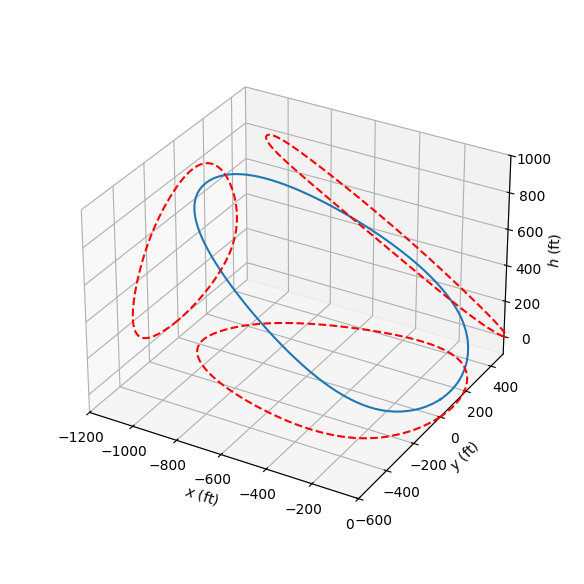

In [11]:
# %matplotlib notebook

plt.figure(1, figsize=(6, 6))
ax = plt.axes(projection=Axes3D.name)
ax.plot3D(x, y, h)
ax.plot3D(0 * x - 1200, y, h, "r--")
ax.plot3D(x, 0 * y + 500, h, "r--")
ax.plot3D(x, y, 0 * h - 100, "r--")
ax.set_xlim([-1200, 0])
ax.set_ylim([-600, 500])
ax.set_zlim([-100, 1000])
ax.set_xlabel(r"$x$ (ft)", fontsize=10)
ax.set_ylabel(r"$y$ (ft)", fontsize=10)
ax.set_zlabel(r"$h$ (ft)", fontsize=10)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.tick_params(axis="z", labelsize=10)
ax.set_box_aspect(None, zoom=0.85)
# ax.view_init(elev=30, azim=45)
plt.tight_layout()

### Lift Coefficient History

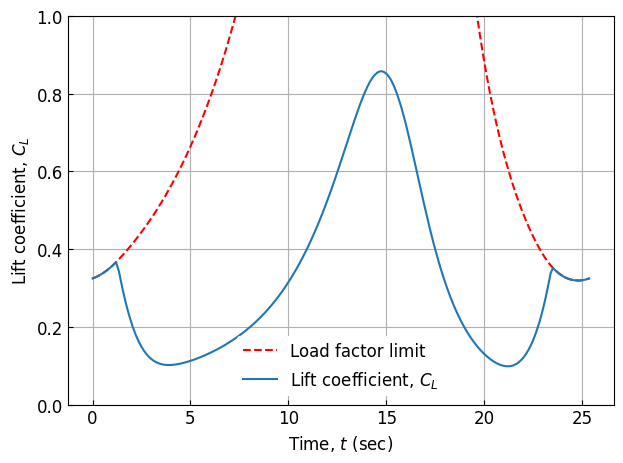

In [12]:
plt.figure()
limit = 5 * (auxdata.m * auxdata.g0) / (0.5 * auxdata.rho0 * auxdata.s * v**2)
plt.plot(t, limit, "r--")
plt.plot(tc, cl)
plt.ylim([0, 1])
legend = plt.legend(["Load factor limit", "Lift coefficient, $C_{L}$"])
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(1)
legend.get_frame().set_linewidth(0)
plt.xlabel(r"Time, $t$ (sec)")
plt.ylabel(r"Lift coefficient, $C_L$")
plt.tight_layout()
plt.grid()

### Velocity History

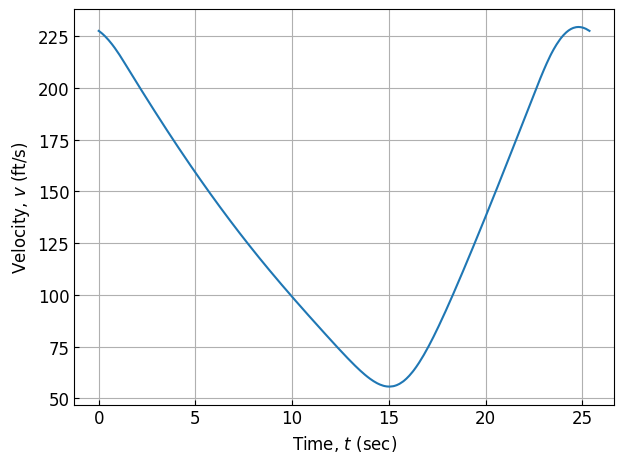

In [13]:
plt.figure(3)
plt.plot(t, v)
plt.xlabel(r"Time, $t$ (sec)")
plt.ylabel(r"Velocity, $v$ (ft/s)")
plt.tight_layout()
plt.grid()

### Flight Path Angle History

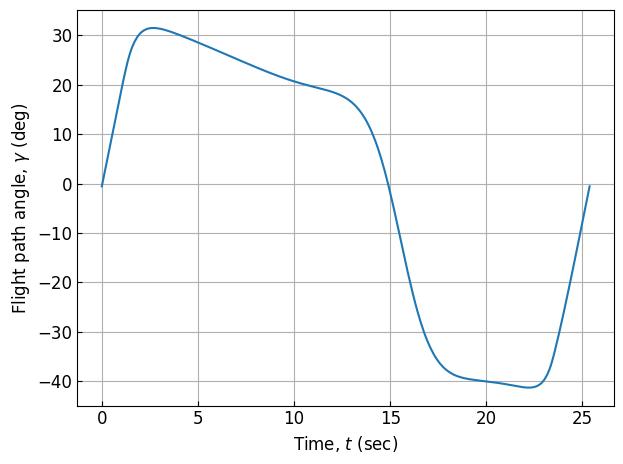

In [14]:
# Plot the flight path angle
plt.figure(4)
plt.plot(t, np.rad2deg(gamma))
plt.xlabel(r"Time, $t$ (sec)")
plt.ylabel(r"Flight path angle, $\gamma$ (deg)")
plt.tight_layout()
plt.grid()

### Heading Angle History

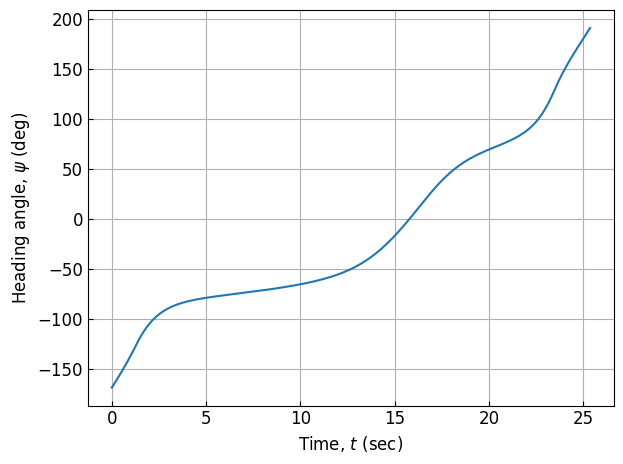

In [15]:
plt.figure(5)
plt.plot(t, np.rad2deg(psi))
plt.xlabel(r"Time, $t$ (sec)")
plt.ylabel(r"Heading angle, $\psi$ (deg)")
plt.tight_layout()
plt.grid()

### Bank Angle History

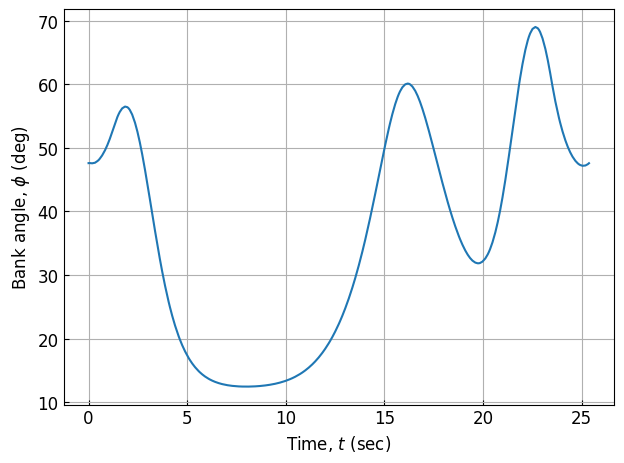

In [16]:
plt.figure(6)
plt.plot(tc, np.rad2deg(phi))
plt.xlabel(r"Time, $t$ (sec)")
plt.ylabel(r"Bank angle, $\phi$ (deg)")
plt.tight_layout()
plt.grid()

### Hamiltonian

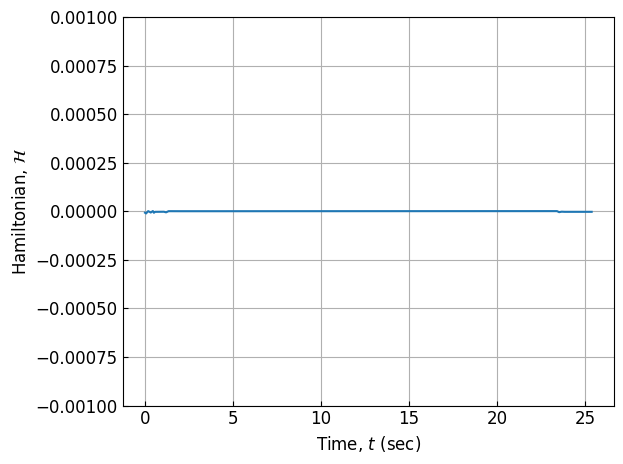

In [17]:
hamiltonian = solution.phase[0].hamiltonian

plt.figure(7)
plt.plot(tc, hamiltonian)
plt.ylim([-0.001, 0.001])
plt.xlabel(r"Time, $t$ (sec)")
plt.ylabel(r"Hamiltonian, $\mathcal{H}$")
plt.tight_layout()
plt.grid()

## References